## Importing libraries and PFR geometry

In [1]:
import numpy as np
import math
from PDESystems.pfr_pde import PfrIpoptEnv
from Encoders.utils_data_gen import generate_pca_dataset
import torch
from Encoders.pca_model import train_pca_on_primals, PcaWarmLibrary
from Encoders.autoencoder import train_autoencoder_on_primals, AeWarmLibrary, PrimalsAutoencoder
from Encoders.variational_autoncoder import train_vae_on_primals, VaeWarmLibrary, PrimalsVAE
import matplotlib.pyplot as plt
from Encoders.regressor_train import train_latent_regressor, LatentRegressor
from sklearn.preprocessing import StandardScaler
import joblib

In [2]:
# Device
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
D_tube = 0.126
A_t = math.pi * (D_tube / 2.0) ** 2

params = {
    # geometry
    "A_t":   A_t,

    # inlet
    "cA_in": 80.0,
    "cB_in": 0.0,
    "cC_in": 0.0,
    "T_in": 423.0,

    # kinetics
    "Rgas": 8.314,
    "k01": 0.1, # 1/h
    "E1": 33475.0, # J/mol
    "k02": 9.0e-7, # m^3/(mol*h)
    "E2": 75319.0, # J/mol

    # heats of reaction (exothermic)
    "dH1": -20.0e3, # J/mol
    "dH2": -60.0e3, # J/mol

    # heat transfer per volume + volumetric heat capacity
    "Ua": 8524.0 * 1e3, # J/(m^3*h*K)
    "rhoCp": 8.0e5, # J/(m^3*K)

    # MV bounds
    "F_min": 0.6,
    "F_max": 4.5,
    "Tj_min": 298.0,
    "Tj_max": 600.0,

    # path/safety bounds on Tr
    "T_lo": 280.0,
    "T_hi": 700.0,
}

## Data Generation

In [4]:
pca_env = PfrIpoptEnv(
    params=params,
    N=10,
    K=20,
    L=20.0,
    dt=0.02,
    target_species="B",
    n_zones=5,
    max_iter=500,
)

In [5]:
feats_data, X_data, sp_data = generate_pca_dataset(
    pca_env,
    num_samples=5000,
    sp_low=20.0,
    sp_high=55.0,
    lam_prim=1.0,
    lam_dual=0.0,
    tee=False,
)

[PCA DATA] k=200/4999, s_prev=26.99, s_curr=28.40, iters=26, time=0.279s
[PCA DATA] k=400/4999, s_prev=31.81, s_curr=26.27, iters=20, time=0.282s
[PCA DATA] k=600/4999, s_prev=23.52, s_curr=47.05, iters=33, time=0.275s
[PCA DATA] k=800/4999, s_prev=39.82, s_curr=31.94, iters=21, time=0.280s
[PCA DATA] k=1000/4999, s_prev=27.14, s_curr=23.65, iters=26, time=0.276s
[PCA DATA] k=1200/4999, s_prev=42.59, s_curr=31.67, iters=41, time=0.379s
[PCA DATA] k=1400/4999, s_prev=50.73, s_curr=50.18, iters=21, time=0.279s
[PCA DATA] k=1600/4999, s_prev=48.60, s_curr=21.92, iters=60, time=0.579s
[PCA DATA] k=1800/4999, s_prev=30.18, s_curr=43.73, iters=26, time=0.282s
[PCA DATA] k=2000/4999, s_prev=44.97, s_curr=45.72, iters=15, time=0.165s
[PCA DATA] k=2200/4999, s_prev=32.67, s_curr=25.93, iters=22, time=0.277s
[PCA DATA] k=2400/4999, s_prev=50.61, s_curr=43.30, iters=30, time=0.378s
[PCA DATA] k=2600/4999, s_prev=39.30, s_curr=32.15, iters=21, time=0.276s
[PCA DATA] k=2800/4999, s_prev=37.81, s_cu

## Training PCA, AE, VAE

In [6]:
feat_scaler = StandardScaler().fit(feats_data)
feats_scaled = feat_scaler.transform(feats_data)
joblib.dump(feat_scaler, r"checkpoints\feat_scaler_pca.joblib")

['checkpoints\\feat_scaler_pca.joblib']

### PCA

In [14]:
# ---- train PCA ----
scaler, pca, Z_data = train_pca_on_primals(X_data, var_threshold=0.99)
print(f"[PCA] Latent codes Z shape: {Z_data.shape}")

# 2) train regressor with scaled Z
pca_reg, z_scaler = train_latent_regressor(
    feats=feats_scaled,
    Z=Z_data,
    hidden_dims=(64, 64),
    batch_size=128,
    num_epochs=2000,
    lr=1e-3,
    device=device,
    standardize_Z=True,
)

# 3) lib
pca_lib = PcaWarmLibrary(
    feats=feats_data,
    Z_latent=Z_data,
    pca=pca,
    scaler=scaler,
    coarse_env=pca_env,
    feat_scaler=feat_scaler,
    z_scaler=z_scaler,
)
pca_lib.attach_regressor(pca_reg, device=device)

pca_lib.save(r"checkpoints\pca_warm_lib.joblib")
torch.save(pca_reg.state_dict(), r"checkpoints\pca_latent_regressor.pth")

[PCA] Fitting PCA on X with shape (5000, 966) ...
[PCA] Components needed for 99.0% variance: r=10
[PCA] Reconstruction MSE in scaled space: 7.693e-03
[PCA] Latent codes Z shape: (5000, 10)
[Regressor] epoch 200/2000 | MSE_z_scaled=1.298e-01
[Regressor] epoch 400/2000 | MSE_z_scaled=1.175e-01
[Regressor] epoch 600/2000 | MSE_z_scaled=1.132e-01
[Regressor] epoch 800/2000 | MSE_z_scaled=1.109e-01
[Regressor] epoch 1000/2000 | MSE_z_scaled=1.094e-01
[Regressor] epoch 1200/2000 | MSE_z_scaled=1.087e-01
[Regressor] epoch 1400/2000 | MSE_z_scaled=1.082e-01
[Regressor] epoch 1600/2000 | MSE_z_scaled=1.072e-01
[Regressor] epoch 1800/2000 | MSE_z_scaled=1.067e-01
[Regressor] epoch 2000/2000 | MSE_z_scaled=1.063e-01


In [15]:
# 1) Load library (PCA + scalers + Z_data)
pca_lib = PcaWarmLibrary.load(r"checkpoints\pca_warm_lib.joblib", coarse_env=pca_env)

# 2) Rebuild regressor with same dims
in_dim = pca_lib.feats.shape[1]
out_dim = pca_lib.Z_latent.shape[1]

pca_reg = LatentRegressor(in_dim=in_dim, out_dim=out_dim, hidden_dims=(64, 64))
state_dict = torch.load(r"checkpoints\pca_latent_regressor.pth", map_location=device)
pca_reg.load_state_dict(state_dict)
pca_reg.to(device).eval()

# 3) Attach regressor to library
pca_lib.attach_regressor(pca_reg, device=device)

### Autoencoder

In [16]:
# ---- train AE ----
scaler_ae, ae_model, X_scaled_ae, X_recon_ae = train_autoencoder_on_primals(
    X_data,
    latent_dim=32,
    batch_size=128,
    num_epochs=2500,
    lr=1e-3,
    device=device,
)

# ---- compute AE latent codes Z_ae on scaled X ----
with torch.no_grad():
    X_scaled_t = torch.from_numpy(X_scaled_ae.astype(np.float32))
    Z_ae = ae_model.encode(X_scaled_t).cpu().numpy()  # (N, latent_dim)

# ---- train regressor feats_scaled -> Z_ae_scaled ----
ae_reg, z_scaler_ae = train_latent_regressor(
    feats=feats_scaled,
    Z=Z_ae,
    hidden_dims=(64, 64),
    batch_size=128,
    num_epochs=2000,
    lr=1e-3,
    device=device,
    standardize_Z=True,
)

# ---- build AE warm library with regressor + decoder ----
ae_lib = AeWarmLibrary(
    feats=feats_data,
    X_recon=X_recon_ae,
    scaler=scaler_ae,
    coarse_env=pca_env,
    Z_latent=Z_ae,
    feat_scaler=feat_scaler,
    z_scaler=z_scaler_ae,
    regressor=ae_reg,
    regressor_device=device,
    decoder=ae_model.decoder,
)

ae_lib.save(r"checkpoints\ae_warm_lib.joblib")
torch.save(ae_reg.state_dict(), r"checkpoints\ae_latent_regressor.pth")
torch.save(ae_model.state_dict(), r"checkpoints\ae_model.pth")

[AE] Training autoencoder on X with shape (5000, 966), latent_dim=32
[AE] Epoch   1/2500, MSE=2.7431e-01
[AE] Epoch  10/2500, MSE=5.2449e-03
[AE] Epoch  20/2500, MSE=3.1140e-03
[AE] Epoch  30/2500, MSE=1.3590e-03
[AE] Epoch  40/2500, MSE=1.5672e-03
[AE] Epoch  50/2500, MSE=1.2130e-03
[AE] Epoch  60/2500, MSE=3.9669e-03
[AE] Epoch  70/2500, MSE=1.1004e-03
[AE] Epoch  80/2500, MSE=4.4333e-04
[AE] Epoch  90/2500, MSE=1.4496e-03
[AE] Epoch 100/2500, MSE=6.2706e-04
[AE] Epoch 110/2500, MSE=2.9733e-03
[AE] Epoch 120/2500, MSE=3.3908e-04
[AE] Epoch 130/2500, MSE=4.9107e-04
[AE] Epoch 140/2500, MSE=2.9788e-03
[AE] Epoch 150/2500, MSE=3.3290e-04
[AE] Epoch 160/2500, MSE=8.5147e-04
[AE] Epoch 170/2500, MSE=7.0837e-04
[AE] Epoch 180/2500, MSE=2.9850e-04
[AE] Epoch 190/2500, MSE=1.1325e-02
[AE] Epoch 200/2500, MSE=2.9935e-04
[AE] Epoch 210/2500, MSE=4.3489e-04
[AE] Epoch 220/2500, MSE=2.4729e-03
[AE] Epoch 230/2500, MSE=4.2799e-04
[AE] Epoch 240/2500, MSE=3.1180e-04
[AE] Epoch 250/2500, MSE=4.4998

In [17]:
# 1) load library
ae_lib = AeWarmLibrary.load(r"checkpoints\ae_warm_lib.joblib", coarse_env=pca_env)

# 2) rebuild AE model with same sizes
input_dim = ae_lib.scaler.mean_.shape[0]     # D (number of primals)
latent_dim = ae_lib.Z_latent.shape[1]        # r (latent dimension)

ae_model = PrimalsAutoencoder(input_dim=input_dim, latent_dim=latent_dim)
ae_model.load_state_dict(torch.load(r"checkpoints\ae_model.pth", map_location=device))
ae_model.to(device).eval()

# 3) rebuild and attach regressor
in_dim = ae_lib.feats.shape[1]       # 3
out_dim = ae_lib.Z_latent.shape[1]   # r
ae_reg = LatentRegressor(in_dim=in_dim, out_dim=out_dim, hidden_dims=(64, 64))
ae_reg.load_state_dict(torch.load(r"checkpoints\ae_latent_regressor.pth", map_location=device))
ae_reg.to(device).eval()

ae_lib.attach_regressor(ae_reg, device=device)
ae_lib.attach_decoder(ae_model.decoder)

### Variational Autoencoder

In [18]:
scaler_vae, vae_model, X_scaled_vae, X_recon_vae, Z_mu = train_vae_on_primals(
    X_data,
    latent_dim=32,
    beta=1.0,
    batch_size=128,
    num_epochs=2500,
    lr=1e-3,
    device=device,
)

# regressor: feats_scaled -> Z_mu_scaled
vae_reg, z_scaler_vae = train_latent_regressor(
    feats=feats_scaled,
    Z=Z_mu,
    hidden_dims=(64, 64),
    batch_size=128,
    num_epochs=2000,
    lr=1e-3,
    device=device,
    standardize_Z=True,
)

vae_lib = VaeWarmLibrary(
    feats=feats_data,
    X_recon=X_recon_vae,
    Z_mu=Z_mu,
    scaler=scaler_vae,
    coarse_env=pca_env,
    feat_scaler=feat_scaler,
    z_scaler=z_scaler_vae,
    regressor=vae_reg,
    regressor_device=device,
    decoder=vae_model.decoder,
)

vae_lib.save(r"checkpoints\vae_warm_lib.joblib")
torch.save(vae_reg.state_dict(), r"checkpoints\vae_latent_regressor.pth")
torch.save(vae_model.state_dict(), r"checkpoints\vae_model.pth")

[VAE] epoch 250/2500 | rec=4.0601e-02, kl=9.9837e-02, beta=1.00
[VAE] epoch 500/2500 | rec=4.0423e-02, kl=9.8828e-02, beta=1.00
[VAE] epoch 750/2500 | rec=3.9594e-02, kl=9.9210e-02, beta=1.00
[VAE] epoch 1000/2500 | rec=3.8312e-02, kl=9.9241e-02, beta=1.00
[VAE] epoch 1250/2500 | rec=3.7855e-02, kl=9.8830e-02, beta=1.00
[VAE] epoch 1500/2500 | rec=3.9587e-02, kl=9.9170e-02, beta=1.00
[VAE] epoch 1750/2500 | rec=3.7433e-02, kl=9.8766e-02, beta=1.00
[VAE] epoch 2000/2500 | rec=3.8185e-02, kl=9.8487e-02, beta=1.00
[VAE] epoch 2250/2500 | rec=3.7605e-02, kl=9.8271e-02, beta=1.00
[VAE] epoch 2500/2500 | rec=3.7956e-02, kl=9.9542e-02, beta=1.00
[Regressor] epoch 200/2000 | MSE_z_scaled=1.528e-01
[Regressor] epoch 400/2000 | MSE_z_scaled=1.463e-01
[Regressor] epoch 600/2000 | MSE_z_scaled=1.413e-01
[Regressor] epoch 800/2000 | MSE_z_scaled=1.391e-01
[Regressor] epoch 1000/2000 | MSE_z_scaled=1.369e-01
[Regressor] epoch 1200/2000 | MSE_z_scaled=1.500e-01
[Regressor] epoch 1400/2000 | MSE_z_sca

In [19]:
vae_lib = VaeWarmLibrary.load(r"checkpoints\vae_warm_lib.joblib", coarse_env=pca_env)

input_dim = vae_lib.scaler.mean_.shape[0]
latent_dim = vae_lib.Z_mu.shape[1]

vae_model = PrimalsVAE(in_dim=input_dim, latent_dim=latent_dim)
vae_model.load_state_dict(torch.load(r"checkpoints\vae_model.pth", map_location=device))
vae_model.to(device).eval()

in_dim = vae_lib.feats.shape[1]   # 3
out_dim = vae_lib.Z_mu.shape[1]   # latent_dim
vae_reg = LatentRegressor(in_dim=in_dim, out_dim=out_dim, hidden_dims=(64, 64))
vae_reg.load_state_dict(torch.load(r"checkpoints\vae_latent_regressor.pth", map_location=device))
vae_reg.to(device).eval()

vae_lib.attach_regressor(vae_reg, device=device)
vae_lib.attach_decoder(vae_model.decoder)

[VAE LIB] Loaded from checkpoints\vae_warm_lib.joblib, feats shape=(5000, 3), X_recon shape=(5000, 966)


# Comparing these methods together

### On the coarse env

[N=10] s_prev=35.0 -> s_curr=27.3 | PCA iters= 15, AE iters= 26, VAE iters= 26, warm iters= 30, PCA t=0.162s, AE t=0.281s, VAE t=0.274s, warm t=0.288s
[N=10] s_prev=27.3 -> s_curr=29.5 | PCA iters= 18, AE iters=  9, VAE iters= 15, warm iters= 19, PCA t=0.276s, AE t=0.136s, VAE t=0.158s, warm t=0.280s
[N=10] s_prev=29.5 -> s_curr=31.8 | PCA iters= 14, AE iters= 13, VAE iters= 24, warm iters= 12, PCA t=0.175s, AE t=0.154s, VAE t=0.277s, warm t=0.152s
[N=10] s_prev=31.8 -> s_curr=34.1 | PCA iters= 15, AE iters=  9, VAE iters= 21, warm iters= 12, PCA t=0.166s, AE t=0.143s, VAE t=0.277s, warm t=0.144s
[N=10] s_prev=34.1 -> s_curr=36.4 | PCA iters= 12, AE iters= 12, VAE iters= 23, warm iters= 12, PCA t=0.155s, AE t=0.160s, VAE t=0.275s, warm t=0.160s
[N=10] s_prev=36.4 -> s_curr=38.6 | PCA iters= 12, AE iters= 11, VAE iters= 21, warm iters= 11, PCA t=0.154s, AE t=0.145s, VAE t=0.279s, warm t=0.155s
[N=10] s_prev=38.6 -> s_curr=40.9 | PCA iters= 12, AE iters=  8, VAE iters= 23, warm iters= 10

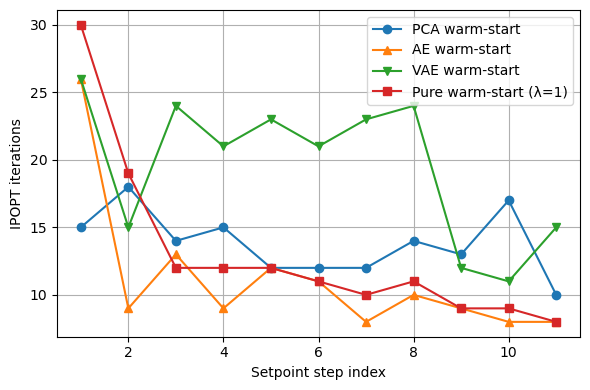

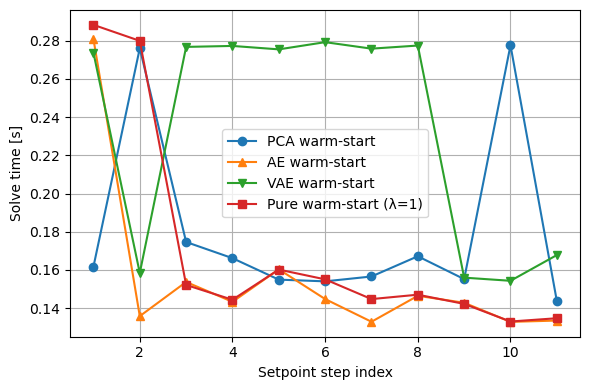

In [20]:
env_pca = PfrIpoptEnv(
    params=params,
    N=10,
    K=20,
    L=20.0,
    dt=0.02,
    target_species="B",
    n_zones=5,
    max_iter=300,
)

env_ae = PfrIpoptEnv(
    params=params,
    N=10,
    K=20,
    L=20.0,
    dt=0.02,
    target_species="B",
    n_zones=5,
    max_iter=300,
)

env_vae = PfrIpoptEnv(
    params=params,
    N=10,
    K=20,
    L=20.0,
    dt=0.02,
    target_species="B",
    n_zones=5,
    max_iter=300,
)

env_warm = PfrIpoptEnv(
    params=params,
    N=10,
    K=20,
    L=20.0,
    dt=0.02,
    target_species="B",
    n_zones=5,
    max_iter=300,
)

# initial solve at starting setpoint
s0 = 35.0
env_pca.reset(s0, tee=False)
# env_ae.reset(s0, tee=False)
# env_vae.reset(s0, tee=False)
env_warm.reset(s0, tee=False)

s_seq = np.linspace(25.0, 50.0, 12)

iters_pca  = []
iters_ae   = []
iters_vae  = []
iters_warm = []

time_pca  = []
time_ae   = []
time_vae  = []
time_warm = []

s_prev = s0

for s_curr in s_seq[1:]:
    # ---------- PCA warm-start ----------
    x_vec_pca = pca_lib.build_fine_primals(
        fine_env=env_pca,
        s_prev=s_prev,
        s_curr=s_curr,
    )
    obs_pca, info_pca = env_pca.step_with_pca_primals(
        s_new=s_curr,
        x_vec=x_vec_pca,
        lam_dual=0.0,
        tee=False,
    )

    # ---------- AE warm-start ----------
    x_vec_ae = ae_lib.build_fine_primals(
        fine_env=env_ae,
        s_prev=s_prev,
        s_curr=s_curr,
    )
    obs_ae, info_ae = env_ae.step_with_pca_primals(
        s_new=s_curr,
        x_vec=x_vec_ae,
        lam_dual=0.0,
        tee=False,
    )

    # ---------- VAE warm-start ----------
    x_vec_vae = vae_lib.build_fine_primals(
        fine_env=env_vae,
        s_prev=s_prev,
        s_curr=s_curr,
    )
    obs_vae, info_vae = env_vae.step_with_pca_primals(
        s_new=s_curr,
        x_vec=x_vec_vae,
        lam_dual=0.0,
        tee=False,
    )

    # ---------- pure warm-start ----------
    obs_warm, info_warm = env_warm.step_no_rl(
        s_new=s_curr,
        lam_prim=1.0,
        lam_dual=0.0,
        tee=False,
    )

    # ---- log stats ----
    iters_pca.append(info_pca["iters"])
    iters_ae.append(info_ae["iters"])
    iters_vae.append(info_vae["iters"])
    iters_warm.append(info_warm["iters"])

    time_pca.append(info_pca["solve_time"])
    time_ae.append(info_ae["solve_time"])
    time_vae.append(info_vae["solve_time"])
    time_warm.append(info_warm["solve_time"])

    print(
        f"[N=10] s_prev={s_prev:.1f} -> s_curr={s_curr:.1f} | "
        f"PCA iters={info_pca['iters']:3d}, "
        f"AE iters={info_ae['iters']:3d}, "
        f"VAE iters={info_vae['iters']:3d}, "
        f"warm iters={info_warm['iters']:3d}, "
        f"PCA t={info_pca['solve_time']:.3f}s, "
        f"AE t={info_ae['solve_time']:.3f}s, "
        f"VAE t={info_vae['solve_time']:.3f}s, "
        f"warm t={info_warm['solve_time']:.3f}s"
    )

    s_prev = s_curr

# ---------- plots ----------
steps = np.arange(1, len(s_seq))

plt.figure(figsize=(6, 4))
plt.plot(steps, iters_pca,  marker="o", label="PCA warm-start")
plt.plot(steps, iters_ae,   marker="^", label="AE warm-start")
plt.plot(steps, iters_vae,  marker="v", label="VAE warm-start")
plt.plot(steps, iters_warm, marker="s", label="Pure warm-start (λ=1)")
plt.xlabel("Setpoint step index")
plt.ylabel("IPOPT iterations")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.figure(figsize=(6, 4))
plt.plot(steps, time_pca,  marker="o", label="PCA warm-start")
plt.plot(steps, time_ae,   marker="^", label="AE warm-start")
plt.plot(steps, time_vae,  marker="v", label="VAE warm-start")
plt.plot(steps, time_warm, marker="s", label="Pure warm-start (λ=1)")
plt.xlabel("Setpoint step index")
plt.ylabel("Solve time [s]")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

### FIne Grid

[N=10] s_prev=35.0 -> s_curr=27.3 | PCA iters= 56, AE iters= 52, VAE iters= 62, warm iters= 48, PCA t=1.732s, AE t=1.630s, VAE t=1.939s, warm t=1.138s
[N=10] s_prev=27.3 -> s_curr=29.5 | PCA iters= 74, AE iters= 57, VAE iters= 77, warm iters= 55, PCA t=2.337s, AE t=1.830s, VAE t=2.434s, warm t=1.435s
[N=10] s_prev=29.5 -> s_curr=31.8 | PCA iters= 38, AE iters= 49, VAE iters= 61, warm iters= 35, PCA t=1.126s, AE t=1.527s, VAE t=2.033s, warm t=0.734s
[N=10] s_prev=31.8 -> s_curr=34.1 | PCA iters= 52, AE iters= 46, VAE iters= 42, warm iters= 38, PCA t=1.926s, AE t=1.632s, VAE t=1.326s, warm t=0.939s
[N=10] s_prev=34.1 -> s_curr=36.4 | PCA iters= 49, AE iters= 49, VAE iters= 54, warm iters= 38, PCA t=1.529s, AE t=1.528s, VAE t=1.732s, warm t=0.933s
[N=10] s_prev=36.4 -> s_curr=38.6 | PCA iters= 49, AE iters= 53, VAE iters= 34, warm iters= 30, PCA t=1.630s, AE t=1.629s, VAE t=1.028s, warm t=1.136s
[N=10] s_prev=38.6 -> s_curr=40.9 | PCA iters= 43, AE iters= 40, VAE iters= 48, warm iters= 26

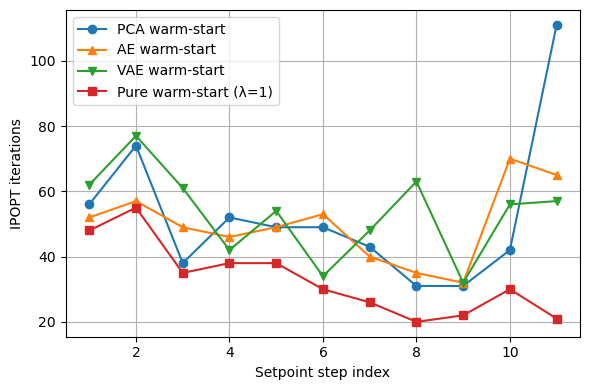

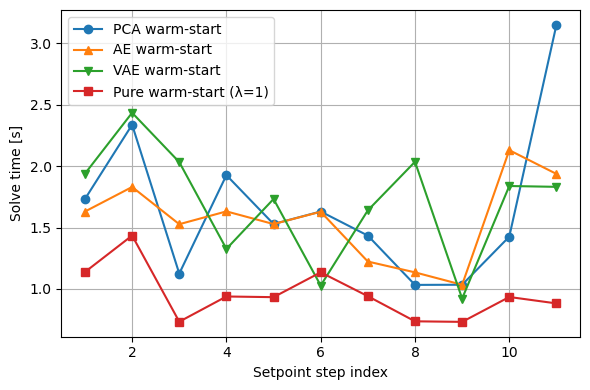

In [21]:
env_pca = PfrIpoptEnv(
    params=params,
    N=20,
    K=20,
    L=20.0,
    dt=0.02,
    target_species="B",
    n_zones=5,
    max_iter=300,
)

env_ae = PfrIpoptEnv(
    params=params,
    N=20,
    K=20,
    L=20.0,
    dt=0.02,
    target_species="B",
    n_zones=5,
    max_iter=300,
)

env_vae = PfrIpoptEnv(
    params=params,
    N=20,
    K=20,
    L=20.0,
    dt=0.02,
    target_species="B",
    n_zones=5,
    max_iter=300,
)

env_warm = PfrIpoptEnv(
    params=params,
    N=20,
    K=20,
    L=20.0,
    dt=0.02,
    target_species="B",
    n_zones=5,
    max_iter=300,
)

# initial solve at starting setpoint
s0 = 35.0
env_pca.reset(s0, tee=False)
env_ae.reset(s0, tee=False)
env_vae.reset(s0, tee=False)
env_warm.reset(s0, tee=False)

s_seq = np.linspace(25.0, 50.0, 12)

iters_pca  = []
iters_ae   = []
iters_vae  = []
iters_warm = []

time_pca  = []
time_ae   = []
time_vae  = []
time_warm = []

s_prev = s0

for s_curr in s_seq[1:]:
    # ---------- PCA warm-start ----------
    x_vec_pca = pca_lib.build_fine_primals(
        fine_env=env_pca,
        s_prev=s_prev,
        s_curr=s_curr,
    )
    obs_pca, info_pca = env_pca.step_with_pca_primals(
        s_new=s_curr,
        x_vec=x_vec_pca,
        lam_dual=0.0,
        tee=False,
    )

    # ---------- AE warm-start ----------
    x_vec_ae = ae_lib.build_fine_primals(
        fine_env=env_ae,
        s_prev=s_prev,
        s_curr=s_curr,
    )
    obs_ae, info_ae = env_ae.step_with_pca_primals(
        s_new=s_curr,
        x_vec=x_vec_ae,
        lam_dual=0.0,
        tee=False,
    )

    # ---------- VAE warm-start ----------
    x_vec_vae = vae_lib.build_fine_primals(
        fine_env=env_vae,
        s_prev=s_prev,
        s_curr=s_curr,
    )
    obs_vae, info_vae = env_vae.step_with_pca_primals(
        s_new=s_curr,
        x_vec=x_vec_vae,
        lam_dual=0.0,
        tee=False,
    )

    # ---------- pure warm-start ----------
    obs_warm, info_warm = env_warm.step_no_rl(
        s_new=s_curr,
        lam_prim=1.0,   # full warm primals
        lam_dual=1.0,   # full dual/bound multipliers reuse
        tee=False,
    )

    # ---- log stats ----
    iters_pca.append(info_pca["iters"])
    iters_ae.append(info_ae["iters"])
    iters_vae.append(info_vae["iters"])
    iters_warm.append(info_warm["iters"])

    time_pca.append(info_pca["solve_time"])
    time_ae.append(info_ae["solve_time"])
    time_vae.append(info_vae["solve_time"])
    time_warm.append(info_warm["solve_time"])

    print(
        f"[N=10] s_prev={s_prev:.1f} -> s_curr={s_curr:.1f} | "
        f"PCA iters={info_pca['iters']:3d}, "
        f"AE iters={info_ae['iters']:3d}, "
        f"VAE iters={info_vae['iters']:3d}, "
        f"warm iters={info_warm['iters']:3d}, "
        f"PCA t={info_pca['solve_time']:.3f}s, "
        f"AE t={info_ae['solve_time']:.3f}s, "
        f"VAE t={info_vae['solve_time']:.3f}s, "
        f"warm t={info_warm['solve_time']:.3f}s"
    )

    s_prev = s_curr

# ---------- plots ----------
steps = np.arange(1, len(s_seq))

plt.figure(figsize=(6, 4))
plt.plot(steps, iters_pca,  marker="o", label="PCA warm-start")
plt.plot(steps, iters_ae,   marker="^", label="AE warm-start")
plt.plot(steps, iters_vae,  marker="v", label="VAE warm-start")
plt.plot(steps, iters_warm, marker="s", label="Pure warm-start (λ=1)")
plt.xlabel("Setpoint step index")
plt.ylabel("IPOPT iterations")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.figure(figsize=(6, 4))
plt.plot(steps, time_pca,  marker="o", label="PCA warm-start")
plt.plot(steps, time_ae,   marker="^", label="AE warm-start")
plt.plot(steps, time_vae,  marker="v", label="VAE warm-start")
plt.plot(steps, time_warm, marker="s", label="Pure warm-start (λ=1)")
plt.xlabel("Setpoint step index")
plt.ylabel("Solve time [s]")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()